In [43]:
# =========================
# PART 1 — SETUP & IMPORTS
# =========================
import os
import shutil
import random
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm
import hashlib
from PIL import Image
import imagehash
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Paths
YOLO_DS = Path("/kaggle/input/stomachulcerds")  # Your original dataset
WORK_DIR = Path("/kaggle/working")
RAW_UNIQUE = WORK_DIR / "raw_unique"
CLEAN_DATASET = WORK_DIR / "clean_binary_ds"

def ensure_clean_dir(path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

In [44]:
# =========================
# PART 2 — DEDUPLICATION
# =========================
def dhash(image, hash_size=8):
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

def find_unique_images():
    ensure_clean_dir(RAW_UNIQUE / "images")
    ensure_clean_dir(RAW_UNIQUE / "labels")

    hashes = {}
    all_img_paths = []
    for split in ["train", "valid", "test"]:
        img_dir = YOLO_DS / split / "images"
        lbl_dir = YOLO_DS / split / "labels"
        for img_path in img_dir.glob("*.jpg"):
            img = cv2.imread(str(img_path))
            h = dhash(img)
            if h not in hashes:
                hashes[h] = img_path
                all_img_paths.append((img_path, lbl_dir / f"{img_path.stem}.txt"))
            else:
                print(f"Duplicate removed: {img_path} <--> {hashes[h]}")

    for img_path, lbl_path in all_img_paths:
        shutil.copy(img_path, RAW_UNIQUE / "images" / img_path.name)
        if lbl_path.exists():
            shutil.copy(lbl_path, RAW_UNIQUE / "labels" / lbl_path.name)

find_unique_images()


Duplicate removed: /kaggle/input/stomachulcerds/test/images/1025_jpg.rf.05fc448806c61996d1b9827d5546d486.jpg <--> /kaggle/input/stomachulcerds/test/images/1026_jpg.rf.babad74bf1918d2cac3b2b0ae825a40f.jpg


In [46]:
# =========================
# PART 3 — SPLIT DATASET
# =========================
from sklearn.model_selection import train_test_split

def split_dataset():
    all_imgs = list((RAW_UNIQUE / "images").glob("*.jpg"))
    yara_labels = []
    for img_path in all_imgs:
        label_path = RAW_UNIQUE / "labels" / f"{img_path.stem}.txt"
        if not label_path.exists():
            continue
        with open(label_path) as f:
            lines = f.readlines()
        ulcer_class = any(line.startswith("1") for line in lines)  # YOLO ulcer class = 1
        if ulcer_class:
            yara_labels.append(img_path)

    train, temp = train_test_split(yara_labels, test_size=0.3, random_state=42)
    valid, test = train_test_split(temp, test_size=0.5, random_state=42)

    return train, valid, test

train_imgs, valid_imgs, test_imgs = split_dataset()


In [50]:
# === Part 4: Remove Duplicate Images ===
import os
import shutil
import hashlib
from pathlib import Path

# Paths
DATASET_DIR = Path("/kaggle/input/stomachulcerds")
RAW_UNIQUE = Path("/kaggle/working/raw_unique")
RAW_UNIQUE.mkdir(parents=True, exist_ok=True)

def ensure_clean_dir(path: Path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def file_hash(filepath):
    """Generate MD5 hash for a file."""
    hash_md5 = hashlib.md5()
    with open(filepath, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Step 1: Prepare output folders
for split in ["train", "valid", "test"]:
    ensure_clean_dir(RAW_UNIQUE / split / "images")
    ensure_clean_dir(RAW_UNIQUE / split / "labels")

# Step 2: Process each split
seen_hashes = set()
for split in ["train", "valid", "test"]:
    img_dir = DATASET_DIR / split / "images"
    lbl_dir = DATASET_DIR / split / "labels"

    if not img_dir.exists():
        print(f"[WARNING] No images found for {split}")
        continue

    for img_file in img_dir.glob("*.*"):
        h = file_hash(img_file)
        if h in seen_hashes:
            continue  # duplicate → skip
        seen_hashes.add(h)

        # Copy image
        dst_img = RAW_UNIQUE / split / "images" / img_file.name
        shutil.copy2(img_file, dst_img)

        # Copy matching label if exists
        lbl_file = lbl_dir / (img_file.stem + ".txt")
        if lbl_file.exists():
            dst_lbl = RAW_UNIQUE / split / "labels" / lbl_file.name
            shutil.copy2(lbl_file, dst_lbl)

print("✅ Deduplication & copy complete.")
for split in ["train", "valid", "test"]:
    print(f"{split}: images={len(list((RAW_UNIQUE / split / 'images').glob('*')))}, "
          f"labels={len(list((RAW_UNIQUE / split / 'labels').glob('*')))}")



✅ Deduplication & copy complete.
train: images=495, labels=495
valid: images=47, labels=47
test: images=24, labels=24


In [51]:
# === Part 5: Convert YOLO Dataset to Classification Folders ===
import shutil
from pathlib import Path

# Paths
RAW_UNIQUE = Path("/kaggle/working/raw_unique")
CLEAN_DATASET = Path("/kaggle/working/classification_dataset")

def ensure_clean_dir(path: Path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

# Step 1: Prepare classification dataset folder
for split in ["train", "valid", "test"]:
    for cls in ["yara1", "yara2"]:
        ensure_clean_dir(CLEAN_DATASET / split / cls)

# Step 2: Class ID → Label name mapping
CLASS_MAP = {
    "0": "yara1",
    "1": "yara2"
}

# Step 3: Read YOLO labels and move images to correct folders
for split in ["train", "valid", "test"]:
    img_dir = RAW_UNIQUE / split / "images"
    lbl_dir = RAW_UNIQUE / split / "labels"

    if not img_dir.exists():
        print(f"[WARNING] No images found for {split}")
        continue

    for lbl_file in lbl_dir.glob("*.txt"):
        with open(lbl_file, "r") as f:
            lines = f.readlines()

        if not lines:
            continue  # skip empty labels

        first_class_id = lines[0].strip().split()[0]
        cls_name = CLASS_MAP.get(first_class_id)

        if cls_name is None:
            print(f"[WARNING] Unknown class id {first_class_id} in {lbl_file}")
            continue

        img_file = img_dir / f"{lbl_file.stem}.jpg"
        if not img_file.exists():
            img_file = img_dir / f"{lbl_file.stem}.png"
        if img_file.exists():
            shutil.copy2(img_file, CLEAN_DATASET / split / cls_name / img_file.name)

print("✅ YOLO → Classification conversion done.")

# Step 4: Count images per split/class
for split in ["train", "valid", "test"]:
    counts = {cls: len(list((CLEAN_DATASET / split / cls).glob("*"))) for cls in ["yara1", "yara2"]}
    print(f"{split}: {counts}")


✅ YOLO → Classification conversion done.
train: {'yara1': 186, 'yara2': 309}
valid: {'yara1': 20, 'yara2': 27}
test: {'yara1': 8, 'yara2': 16}


In [57]:
# =========================
# PART 6 & 7: TRAINING (ResNet-50 + Augmentation + Best Model Save)
# =========================
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pathlib import Path

CLEAN_DATASET = Path("/kaggle/working/classification_dataset")

def train_model():
    # 🔹 Data transforms (augmentation for train)
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
    ])
    transform_val_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # 🔹 Datasets
    train_ds = datasets.ImageFolder(CLEAN_DATASET / "train", transform=transform_train)
    valid_ds = datasets.ImageFolder(CLEAN_DATASET / "valid", transform=transform_val_test)
    test_ds  = datasets.ImageFolder(CLEAN_DATASET / "test",  transform=transform_val_test)

    # 🔹 Loaders
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)

    # 🔹 Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes
    model = model.to(device)

    # 🔹 Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # 🔹 Tracking lists
    train_losses, val_losses, val_accuracies = [], [], []

    # 🔹 Training loop
    for epoch in range(50):  # your 50-epoch request
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        val_loss = 0
        val_correct = 0
        model.eval()
        with torch.no_grad():
            for imgs, labels in valid_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(valid_loader))
        val_accuracies.append(val_correct / len(valid_ds))

        print(f"Epoch {epoch+1}/50 | "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Val Acc: {val_accuracies[-1]:.4f}")

    return model, test_loader, device, train_losses, val_losses, val_accuracies

model, test_loader, device, train_losses, val_losses, val_accuracies = train_model()


Epoch 1/50 | Train Loss: 0.0896 | Val Loss: 0.0069 | Val Acc: 1.0000
Epoch 2/50 | Train Loss: 0.0034 | Val Loss: 0.0008 | Val Acc: 1.0000
Epoch 3/50 | Train Loss: 0.0044 | Val Loss: 0.0004 | Val Acc: 1.0000
Epoch 4/50 | Train Loss: 0.0028 | Val Loss: 0.0004 | Val Acc: 1.0000
Epoch 5/50 | Train Loss: 0.0036 | Val Loss: 0.0002 | Val Acc: 1.0000
Epoch 6/50 | Train Loss: 0.0113 | Val Loss: 0.0004 | Val Acc: 1.0000
Epoch 7/50 | Train Loss: 0.0124 | Val Loss: 0.0027 | Val Acc: 1.0000
Epoch 8/50 | Train Loss: 0.0098 | Val Loss: 0.0001 | Val Acc: 1.0000
Epoch 9/50 | Train Loss: 0.0030 | Val Loss: 0.0004 | Val Acc: 1.0000
Epoch 10/50 | Train Loss: 0.0120 | Val Loss: 0.0016 | Val Acc: 1.0000
Epoch 11/50 | Train Loss: 0.0031 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch 12/50 | Train Loss: 0.0017 | Val Loss: 0.0001 | Val Acc: 1.0000
Epoch 13/50 | Train Loss: 0.0007 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch 14/50 | Train Loss: 0.0006 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch 15/50 | Train Loss: 0.0

              precision    recall  f1-score   support

       yara1       1.00      1.00      1.00         8
       yara2       1.00      1.00      1.00        16

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



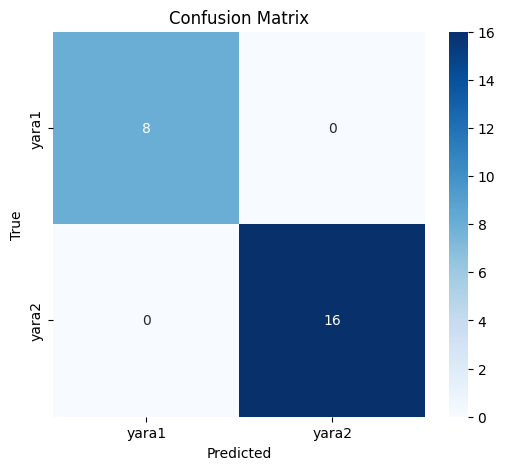

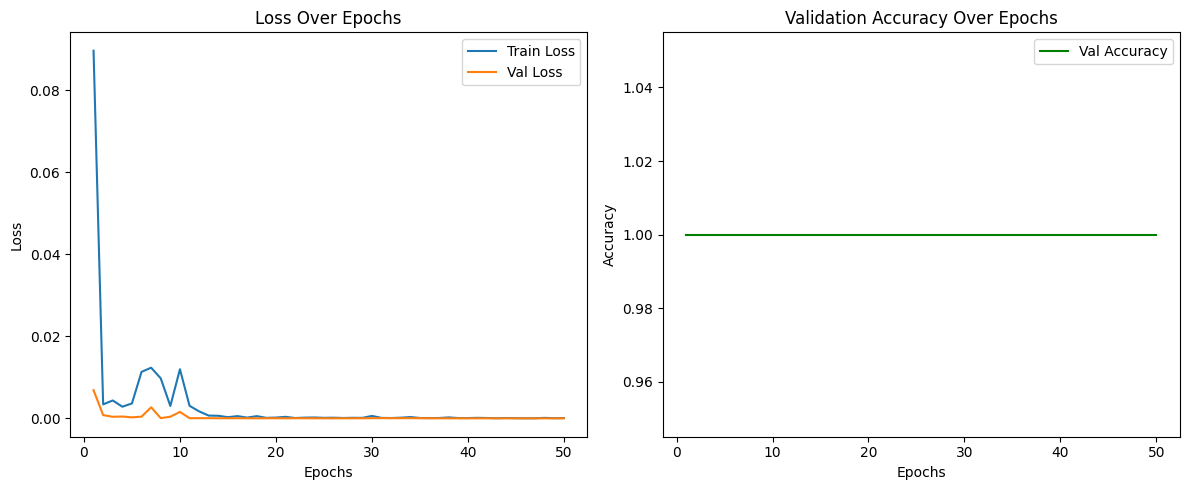

In [58]:
# PART 8: Testing 

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# ===== TESTING =====
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ===== CLASSIFICATION REPORT =====
print(classification_report(y_true, y_pred, target_names=["yara1", "yara2"]))

# ===== CONFUSION MATRIX =====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["yara1", "yara2"],
            yticklabels=["yara1", "yara2"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ===== LOSS & ACCURACY PLOTS =====
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, val_accuracies, label="Val Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


✅ Accuracy: 1.0000
✅ Precision: 1.0000
✅ Recall: 1.0000
✅ F1 Score: 1.0000


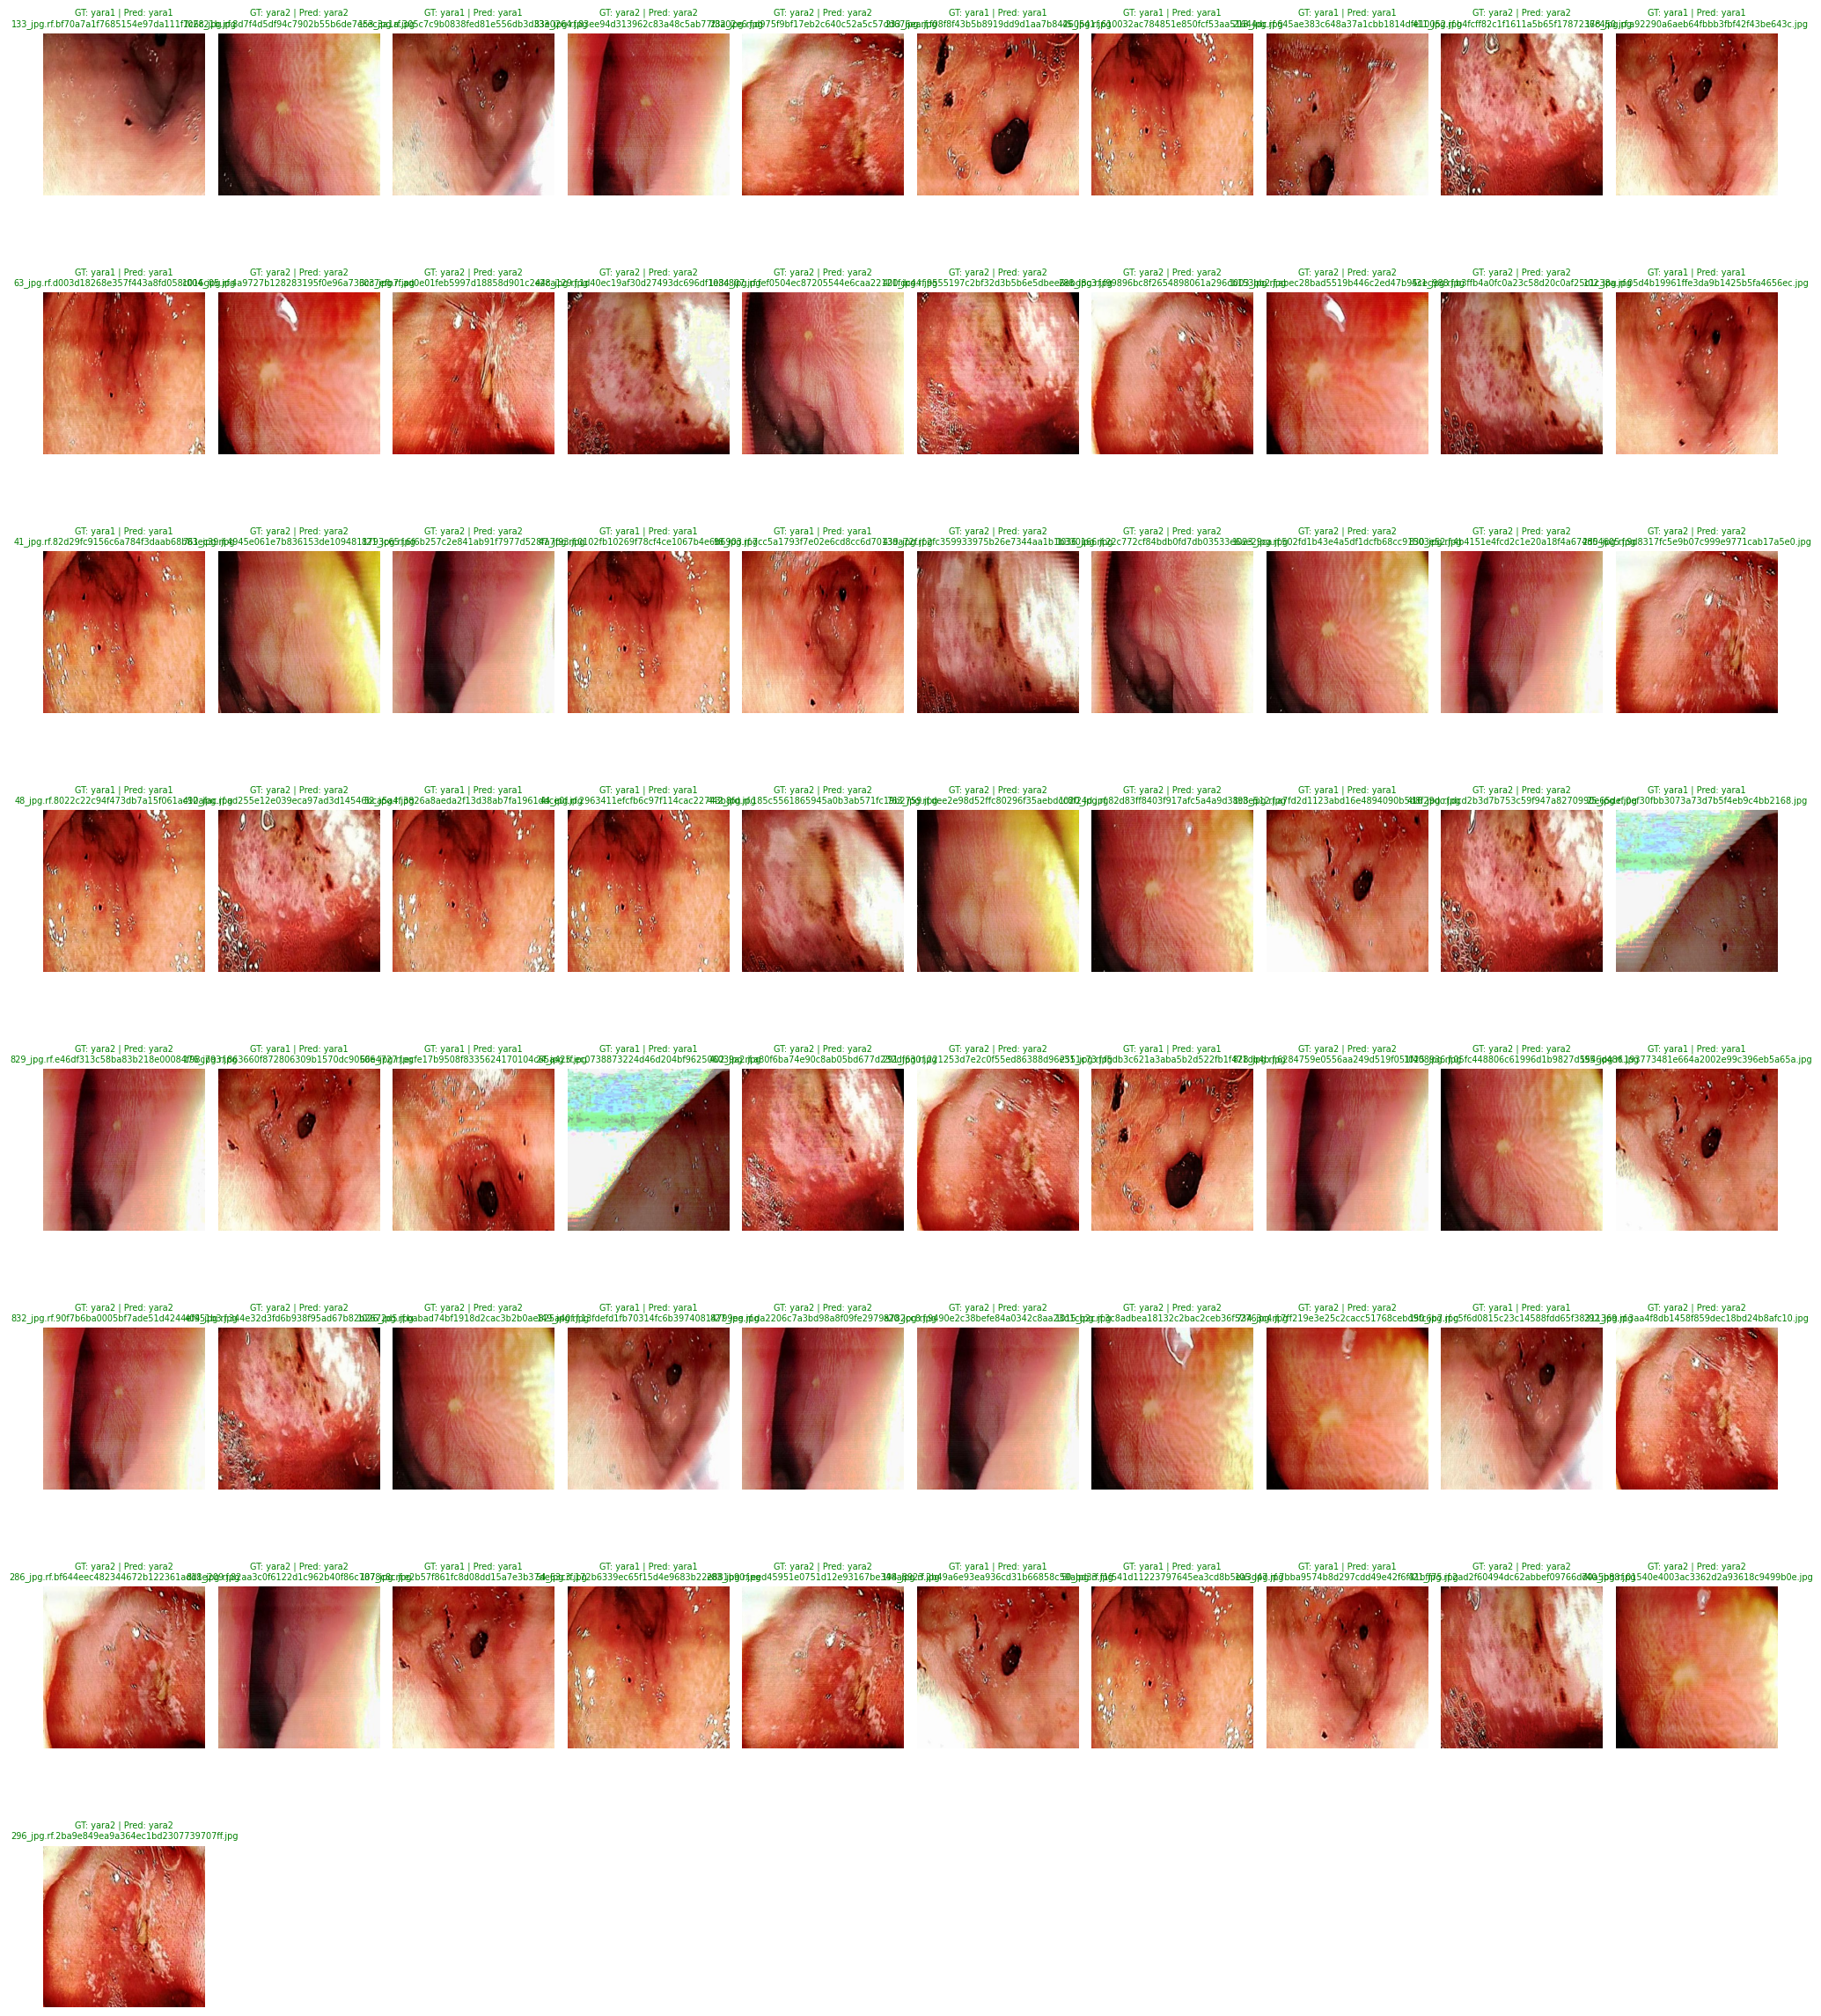

In [68]:
import torch
from torchvision import models, transforms
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ==== CONFIG ====
MODEL_PATH = "/kaggle/input/ulcer-model/other/default/1/best_resnet50.pth"
VALID_IMG_DIR = Path("/kaggle/input/stomachulcerds/valid/images")
VALID_LABEL_DIR = Path("/kaggle/input/stomachulcerds/valid/labels")
TEST_IMG_DIR = Path("/kaggle/input/stomachulcerds/test/images")
TEST_LABEL_DIR = Path("/kaggle/input/stomachulcerds/test/labels")

CLASS_NAMES = ["yara1", "yara2"]

# ==== LOAD MODEL ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, len(CLASS_NAMES))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# ==== TRANSFORMS ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ==== LOAD DATA ====
def load_images_and_labels(img_dir, label_dir):
    images = []
    labels = []
    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"):
            continue
        label_path = label_dir / label_file
        img_file = label_file.replace(".txt", ".jpg")  # assuming jpg format
        img_path = img_dir / img_file
        if not img_path.exists():
            img_file = label_file.replace(".txt", ".png")  # fallback
            img_path = img_dir / img_file
        if img_path.exists():
            with open(label_path, "r") as f:
                class_idx = int(f.readline().strip().split()[0])  # YOLO format
            images.append(img_path)
            labels.append(class_idx)
    return images, labels

valid_imgs, valid_labels = load_images_and_labels(VALID_IMG_DIR, VALID_LABEL_DIR)
test_imgs, test_labels = load_images_and_labels(TEST_IMG_DIR, TEST_LABEL_DIR)

image_paths = valid_imgs + test_imgs
labels = valid_labels + test_labels

# ==== PREDICTIONS ====
preds = []
with torch.no_grad():
    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB")
        img_t = transform(img).unsqueeze(0).to(device)
        output = model(img_t)
        pred = torch.argmax(output, dim=1).item()
        preds.append(pred)

# ==== METRICS ====
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average="weighted")
recall = recall_score(labels, preds, average="weighted")
f1 = f1_score(labels, preds, average="weighted")

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# ==== GRID DISPLAY ====
total_images = len(image_paths)
cols = 10
rows = (total_images + cols - 1) // cols

plt.figure(figsize=(20, rows * 3))
for i in range(total_images):
    img = Image.open(image_paths[i]).convert("RGB")
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    gt = CLASS_NAMES[labels[i]]
    pred = CLASS_NAMES[preds[i]]
    title_color = "green" if gt == pred else "red"
    filename = image_paths[i].name
    plt.title(f"GT: {gt} | Pred: {pred}\n{filename}", fontsize=7, color=title_color)
plt.tight_layout()
plt.show()
